# SMC-ABC Lotka–Volterra example

In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(2)
data = np.random.normal(loc=0, scale=1, size=1000)

/home/agustina/Documents/pymc3/pymc3/step_methods/smc_ABC.py:79: UserWarning: Warning: SMC-ABC methods are experimental step methods and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)


# Lotka–Volterra
In this example we will try to find parameters for the Lotka-Volterra equations. A common competition model for describing how the number of individuals of each species changes when more than one species uses the same resource (Otto, Day, 2007).

In [2]:
from scipy.integrate import odeint

In [3]:
# Definition of parameters
a = 1.
b = 0.1
c = 1.5
d = 0.75

X0 = [10., 5.]
size = 1000
time = 15
t = np.linspace(0, time, size)

def dX_dt(X, t, a, b, c, d):
    """ Return the growth rate of fox and rabbit populations. """

    return np.array([ a*X[0] -   b*X[0]*X[1] , 
                  -c*X[1] + d*b*X[0]*X[1] ])

In [4]:
def simulate(a, b, c, d): 
    return odeint(dX_dt, y0=X0, t=t, rtol=0.1, args=(a, b, c, d))

In [5]:
def add_noise(a, b, c, d):
    noise = np.random.normal(size=(size, 2))
    simulated = simulate(a, b, c, d)
    simulated += noise
    indexes = np.sort(np.random.randint(low=0, high=size, size=size))    
    return simulated[indexes]

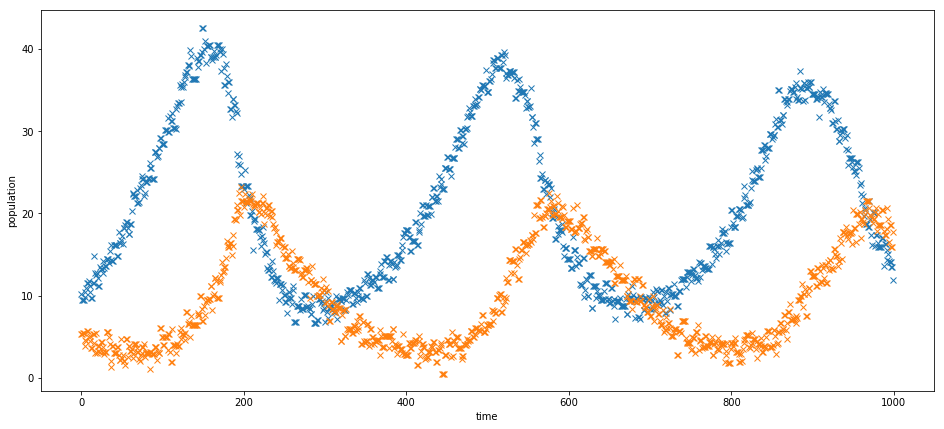

In [6]:
observed = add_noise(a, b, c, d )
_, ax = plt.subplots(figsize=(16,7))
ax.plot(observed, 'x')
ax.set_xlabel('time')
ax.set_ylabel('population');

In [7]:
with pm.Model() as model:
    a = pm.HalfNormal('a', 1, transform=None)
    b = pm.HalfNormal('b', 1, transform=None)
    c = pm.HalfNormal('c', 1, transform=None)
    d = pm.HalfNormal('d', 1, transform=None)
    simulator = pm.Simulator('simulator', simulate, observed=observed)
    trace = pm.sample(step=pm.SMC_ABC(n_steps=50, min_epsilon=70, iqr_scale=3, sum_stat=['mean', 'var']), draws=500)

/home/agustina/Documents/pymc3/pymc3/step_methods/smc_ABC.py:79: UserWarning: Warning: SMC-ABC methods are experimental step methods and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Using absolute difference as distance metric
Using ['mean', 'var'] as summary statistic
Sample initial stage: ...
Sampling stage 0 with Epsilon 33.038134
  9%|▊         | 43/500 [00:02<00:23, 19.51it/s]/home/agustina/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
100%|██████████| 500/500 [00:25<00:00, 19.65it/s]


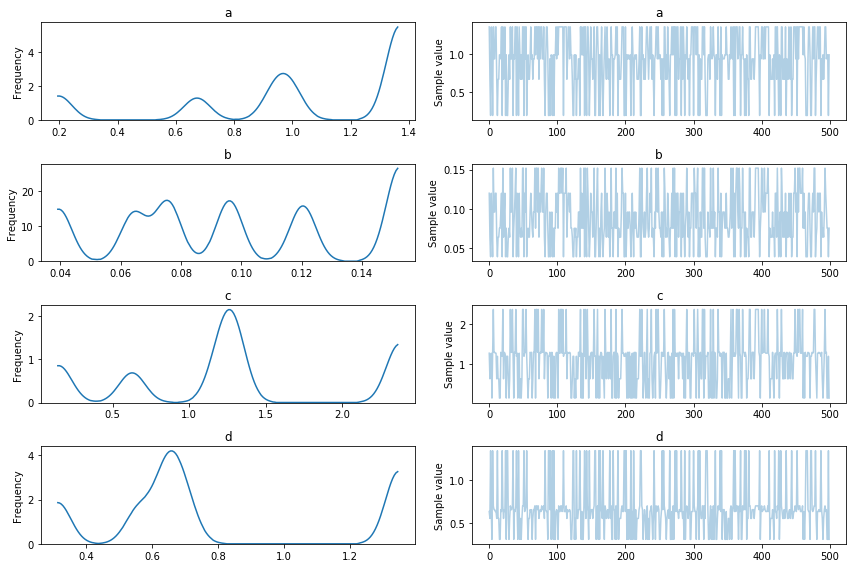

In [8]:
pm.traceplot(trace);

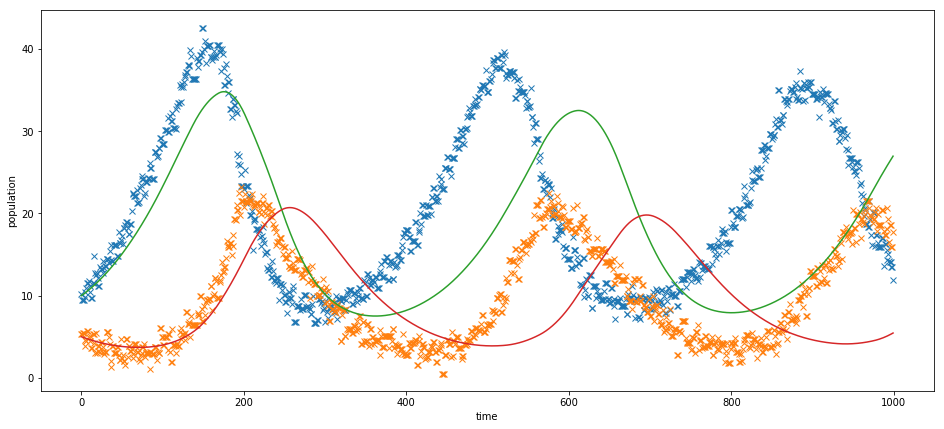

In [9]:
_, ax = plt.subplots(figsize=(16,7))
ax.plot(observed, 'x')
ax.plot(simulate(trace['a'].mean(), trace['b'].mean(), trace['c'].mean(), trace['d'].mean()))
ax.set_xlabel('time')
ax.set_ylabel('population');

In [10]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,0.923255,0.396435,0.017170,0.195072,1.361568
b,0.090614,0.035715,0.001749,0.039182,0.151875
c,1.116505,0.669676,0.035179,0.141202,2.364385
d,0.694043,0.314299,0.011787,0.313403,1.344493
